In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
from matplotlib import rcParams
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

# Normalize amplicon data to dummy origin

In [104]:
import statsmodels
statsmodels.__version__

'0.13.2'

In [105]:
d = pd.read_csv('./ms_data/barcode_results.tsv', sep="\t")
m = pd.read_csv('./ms_data/sample_metadata.csv')
barcodes = [b for b in d.columns if b not in ['Sample','Dummy',]]
m['Strain_library'] = m['Library'].astype(str) + m['Strain_name']

In [106]:
negs = d[d.Sample.isin(m[m.Strain_name.str.contains("negative")]['Sample'])].set_index("Sample") +1 
max_dummy_ratio_in_negs = negs.div(negs.Dummy, axis=0).max().max()
print(max_dummy_ratio_in_negs)

2.142857142857143


In [107]:
zscores = defaultdict(list)

for index, row in d.iterrows():

    
    sample_data =row[barcodes + ["Dummy"]] + 1
    sample_sum = sample_data.sum()
    
    for barcode in barcodes:
        z_result = proportions_ztest([sample_data[barcode],sample_data['Dummy']],[sample_sum,sample_sum])
        zscores['Sample'].append(row['Sample'])
        zscores['Barcode'].append(barcode)
        zscores['zscore'].append(z_result[0])
        zscores['pvalue'].append(z_result[1])
        zscores['count'].append(row[barcode])
        zscores['ratio_to_dummy'].append(row[barcode] / (1+row['Dummy']))
        
zscores = pd.DataFrame(zscores)
zscores['pvalue_bonferroni'] = zscores['pvalue'] * zscores.shape[0]
final_zscore = zscores.pivot(index='Sample',columns='Barcode',values='zscore')
final_pvalue = zscores.pivot(index='Sample',columns='Barcode',values='pvalue_bonferroni')
final_ratios = zscores.pivot(index='Sample',columns='Barcode',values='ratio_to_dummy')

print(round((final_ratios ==  0).sum().sum() / (final_ratios.shape[0]*final_ratios.shape[1]),2))

final_ratios[final_pvalue > 0.01] = 0 # P value cutoff
print(round((final_ratios ==  0).sum().sum() / (final_ratios.shape[0]*final_ratios.shape[1]),2))

final_ratios[final_zscore < 0] = 0 # Only positive with respect to dummy
print(round((final_ratios ==  0).sum().sum() / (final_ratios.shape[0]*final_ratios.shape[1]),2))

final_ratios[final_ratios < max_dummy_ratio_in_negs*5] = 0 # Minimum ratio
print(round((final_ratios ==  0).sum().sum() / (final_ratios.shape[0]*final_ratios.shape[1]),2))

final_ratios = np.log10(final_ratios+1) # Log fold change 

final_ratios = round(final_ratios,1)

final = pd.merge(final_ratios,m, left_index=True, right_on='Sample')
final = final[~final.Sample.isin(negs.index)]

final.to_csv('./ms_data/amplicon_ratios.tsv', index=None, sep="\t")
pd.merge(d,m, left_on='Sample', right_on='Sample').to_csv('./ms_data/raw_read_counts.tsv', index=None, sep="\t")

fig1 = final.query("Method == 'Magmax_Barcode'").groupby(["Strain_library"]).mean()

0.31
0.59
0.85
0.88


/tmp/ipykernel_134162/261041253.py:45: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fig1 = final.query("Method == 'Magmax_Barcode'").groupby(["Strain_library"]).mean()


# Heatmap

In [108]:
g_neg = ['p15A',
'pBBR1',
'pBBR1-UP',
'pSa',
'pSC101ts',
'pWKS1',
'RK2',
'RSF1010']
g_neg = fig1[g_neg].astype(float).sum().sort_values(ascending=False).index


g_pos = ['pAL5000',
'pAMb1',
'pBC1',
'pIJ101',
'pIP501',
'pNG2',
'pSG5',
'pUB110']
g_pos = fig1[g_pos].astype(float).sum().sort_values(ascending=False).index

fungal = ['2m',
'AMA1_short',
'CEN6/ARSH4',
'panARS',
'panARS-OPT',
'UARS1']
fungal = fig1[fungal].astype(float).sum().sort_values(ascending=False).index

barcodes_ordered = list(g_neg) + list(g_pos) + list(fungal)

<AxesSubplot: ylabel='Strain_library'>

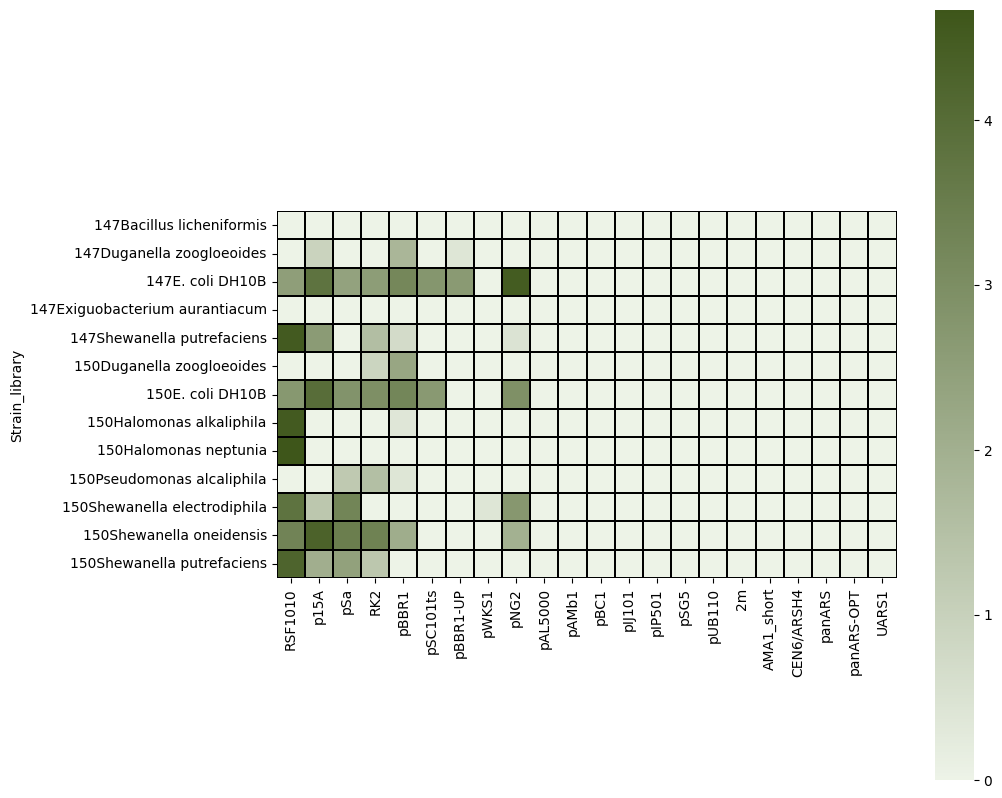

In [109]:
rcParams['figure.figsize'] = 10,10

sns.heatmap(fig1[barcodes_ordered], linewidths=0.01, linecolor='black', rasterized=False, cbar=True,
            cmap=sns.color_palette("light:#3e561a", as_cmap=True), square=True)

# Amplicon vs WGS

In [110]:
barcodes_both = ['pBC1',
 'p15A',
 'pNG2',
 'pSG5',
 'UARS1',
 '2m',
 'pWKS1',
 'pSa',
 'pIJ101',
 'RSF1010',
 'pBBR1',
 'RK2',
 'pSC101ts',
 'panARS-OPT',
 'panARS',
 'AMA1_short',
 'CEN6/ARSH4',
 'pIP501',
 'pAMb1',
 'pUB110',
 'pAL5000']

In [111]:
d2 = pd.read_csv('./ms_data/plasmid_library_coverage.tsv', sep="\t")
d2 = d2.set_index("Sample")

b2 = pd.read_csv('./ms_data/plasmid_library_breadth.tsv', sep="\t")
b2 = b2.set_index("Sample")

d2[b2 < 0.5] = 0
final = pd.merge(d2,m, left_index=True, right_on='FileName')
fig1 = final.query("Method == 'Whole_Plasmid'").groupby(["Strain_library"]).mean()
fig1.columns = [unidecode(x.replace(" ORI","")) for x in fig1.columns]
fig1.columns = fig1.columns.str.replace("AMA1 short","AMA1_short").str.replace("panARS-opt","panARS-OPT")

WPS_data = fig1[barcodes_both].reset_index().melt(id_vars='Strain_library')
WPS_data.columns = ['Strain_library','origin','wps_abund']

/tmp/ipykernel_134162/936848293.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fig1 = final.query("Method == 'Whole_Plasmid'").groupby(["Strain_library"]).mean()


In [112]:
barcode = pd.read_csv('./ms_data/amplicon_ratios.tsv', sep="\t").query("Method == 'Magmax_Barcode'").groupby("Strain_library").mean()
barcode_data = barcode[barcode.columns[barcode.columns.isin(barcodes)]].reset_index().melt(id_vars='Strain_library')
barcode_data.columns = ['Strain_library','origin','barcode_abund']

/tmp/ipykernel_134162/96356749.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  barcode = pd.read_csv('./ms_data/amplicon_ratios.tsv', sep="\t").query("Method == 'Magmax_Barcode'").groupby("Strain_library").mean()


(0.0, 5.0)

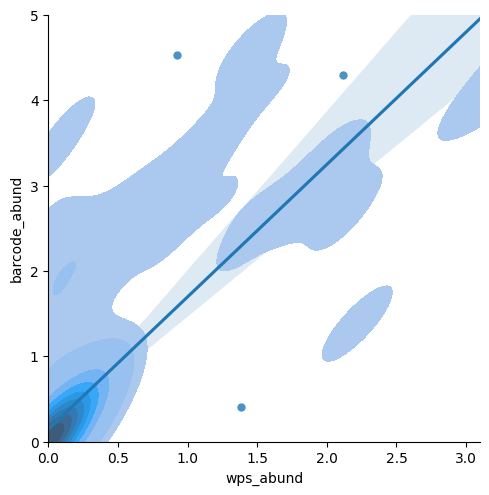

In [113]:
merged = pd.merge(barcode_data, WPS_data, on=['Strain_library','origin'])
merged['wps_abund'] = np.log10(merged['wps_abund'] + 1)

sns.lmplot(data=merged, x='wps_abund', y='barcode_abund', scatter_kws={"linewidth":0})
ax = sns.kdeplot(data=merged, x='wps_abund', y='barcode_abund', fill=True, alpha=1)

plt.xlim(0,3.1)
plt.ylim(0,5)
# plt.xscale("log")
# plt.savefig("Correlation.svg")

In [115]:
from scipy.stats import pearsonr
pearsonr(merged['barcode_abund'], merged['wps_abund'])

PearsonRResult(statistic=0.8040090196813233, pvalue=3.9560524391165725e-63)

# Every strain plotted

In [117]:
barcode = pd.read_csv('./ms_data/amplicon_ratios.tsv', sep="\t").query("Method == 'Magmax_Barcode'")
# barcode[barcodes_ordered] = barcode[barcodes_ordered].div(barcode[barcodes_ordered].sum()).fillna(0)
wps = final.query("Method == 'Whole_Plasmid'")
wps.columns = [unidecode(x.replace(" ORI","")) for x in wps.columns]
wps.columns = wps.columns.str.replace("AMA1 short","AMA1_short").str.replace("panARS-opt","panARS-OPT")
wps = wps.melt(id_vars=['Sample','Strain_library'], value_vars=list(pd.Series(barcodes_ordered)[pd.Series(barcodes_ordered).isin(wps.columns)]))
wps['type'] = 'wps'
barcode = barcode.melt(id_vars=['Sample','Strain_library'], value_vars=barcodes_ordered)
barcode['type'] = 'barcode'
combined_final = pd.concat([wps,barcode])

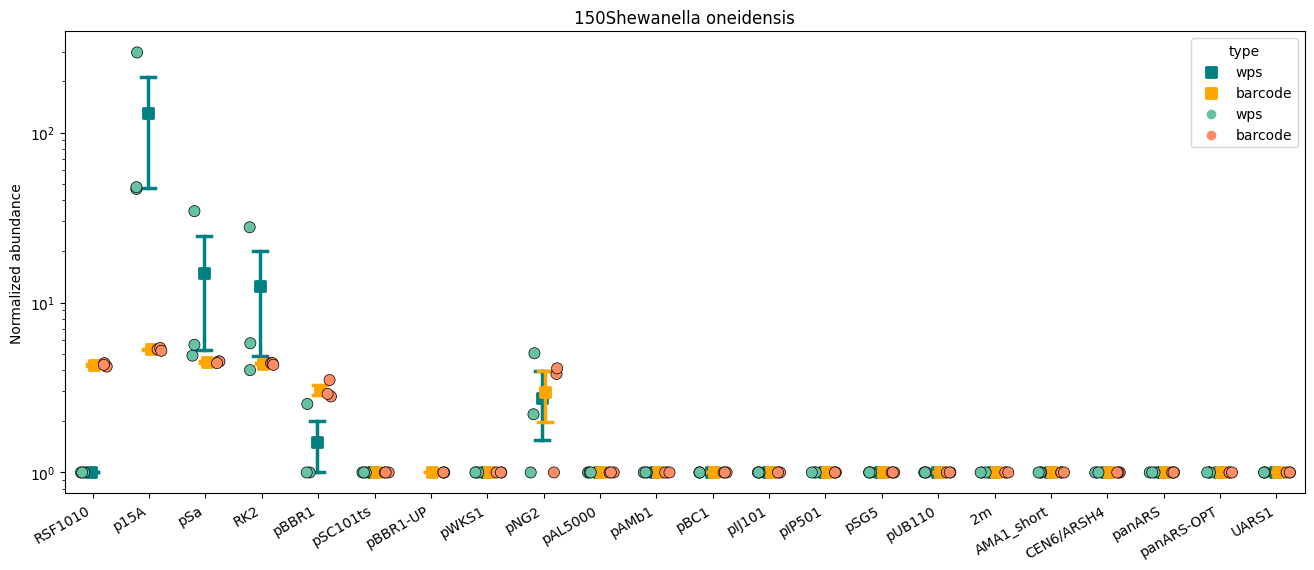

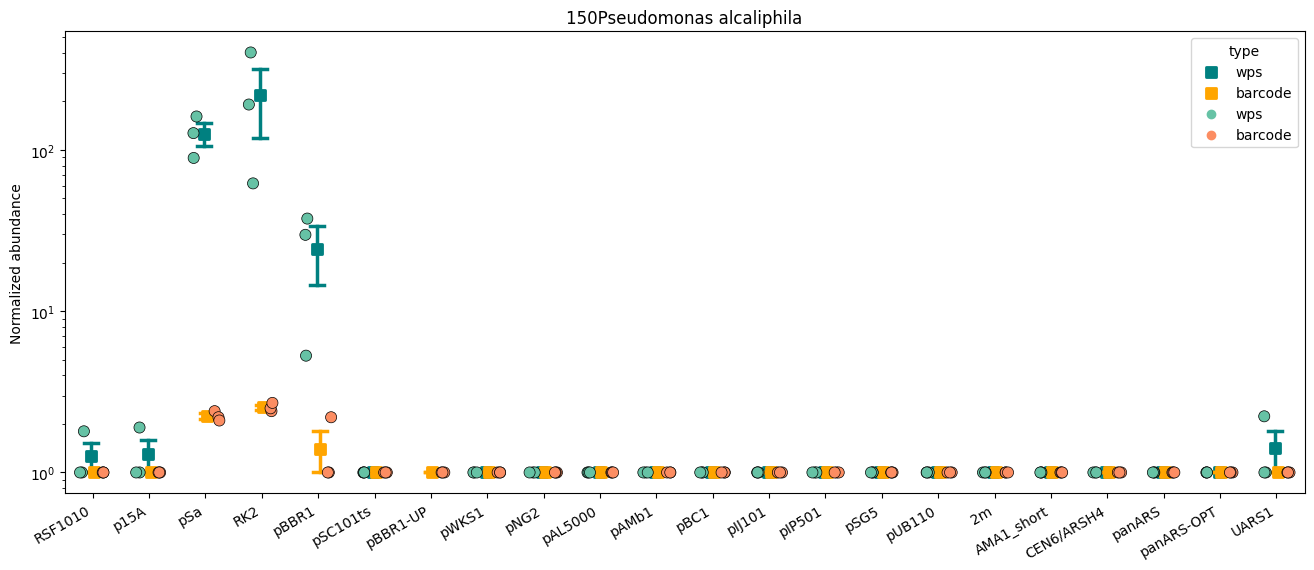

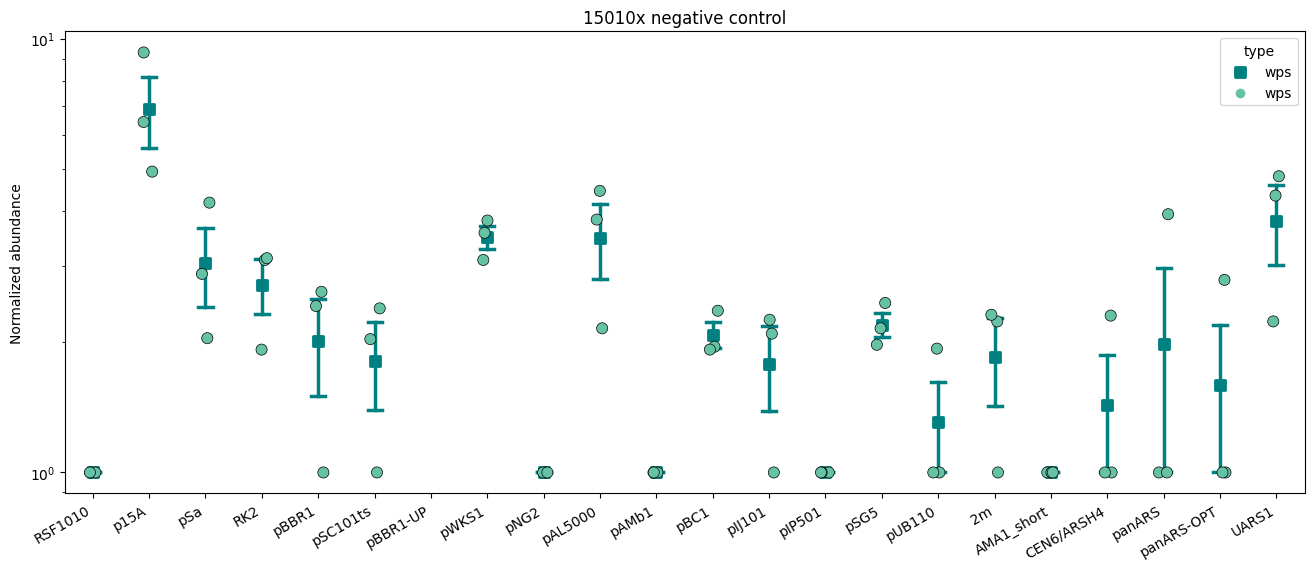

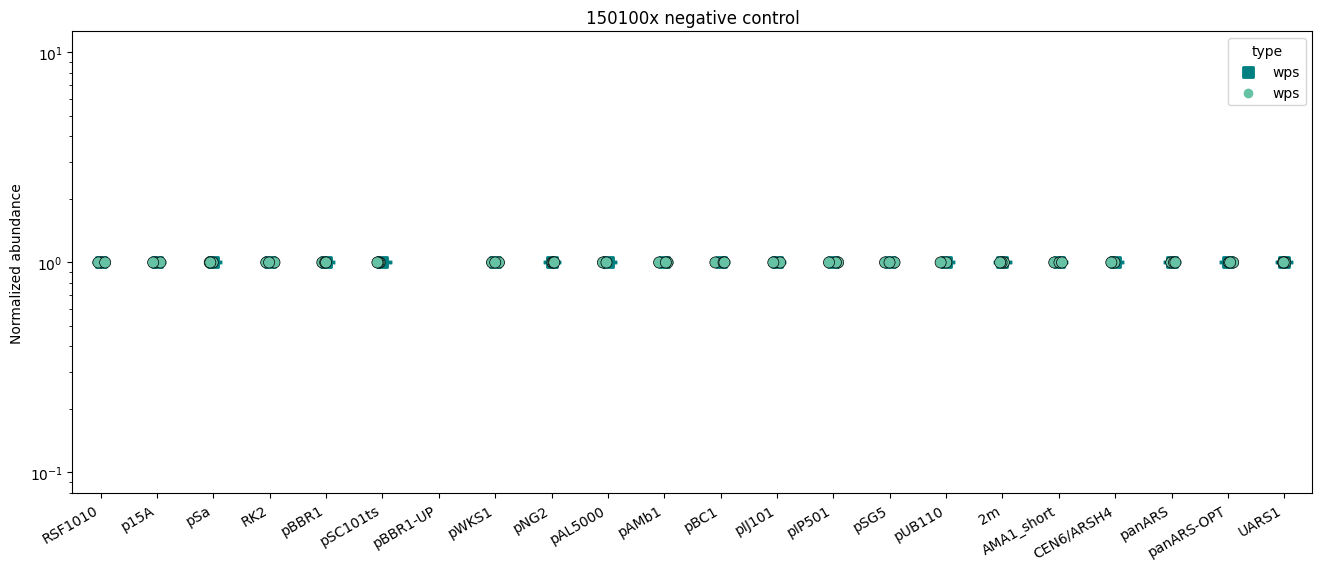

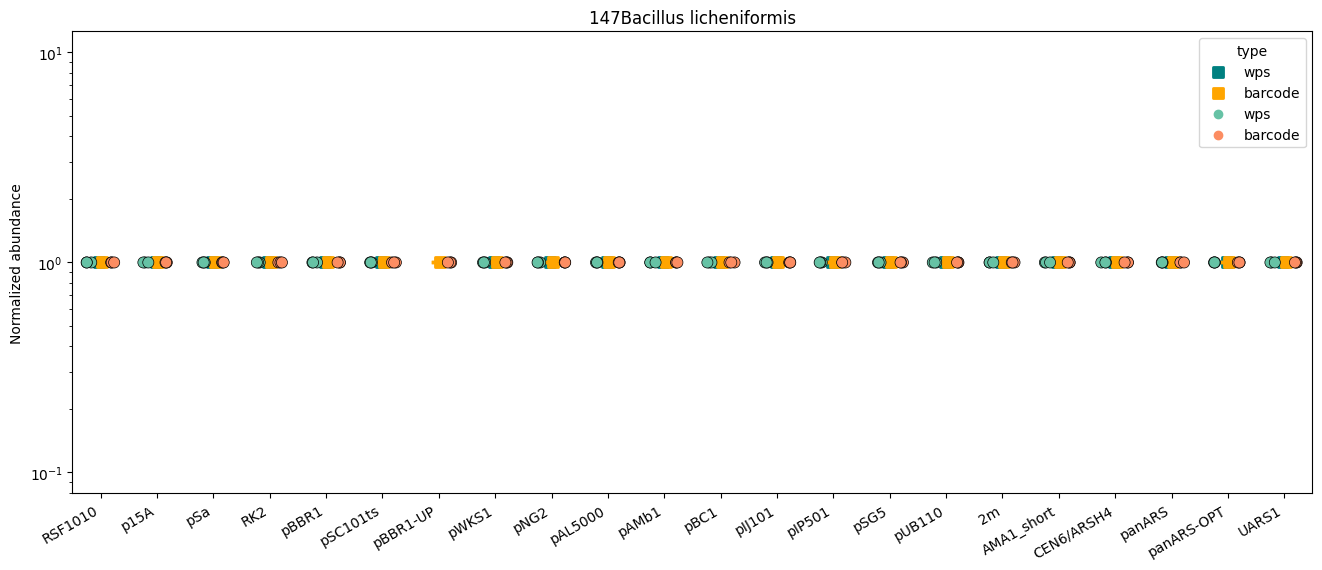

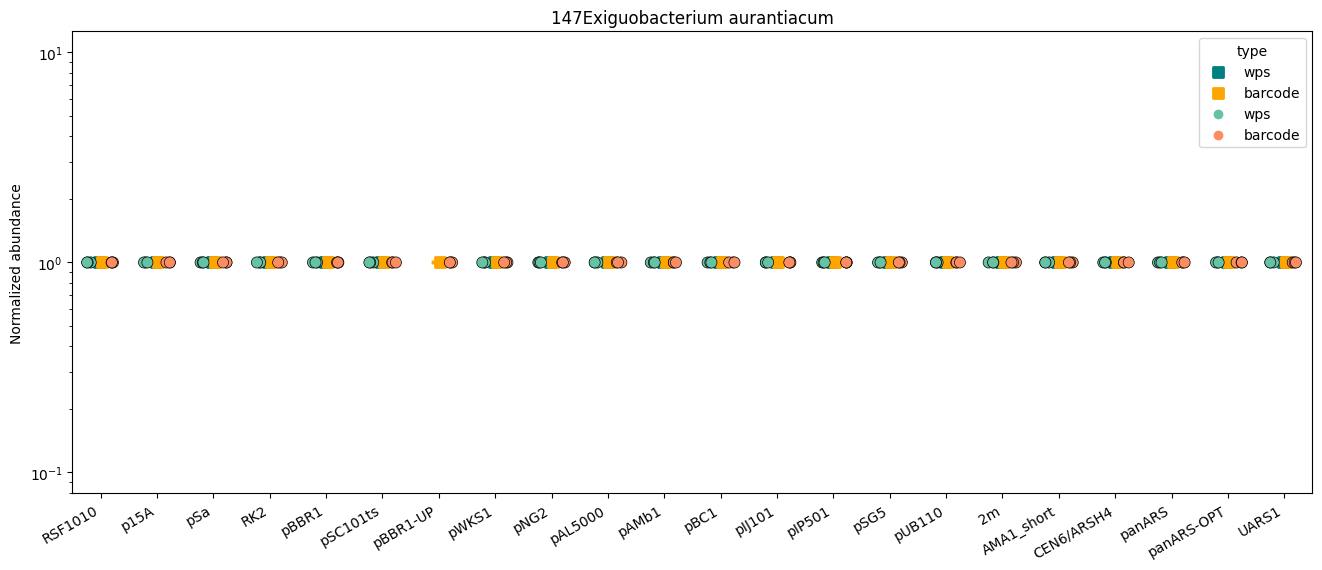

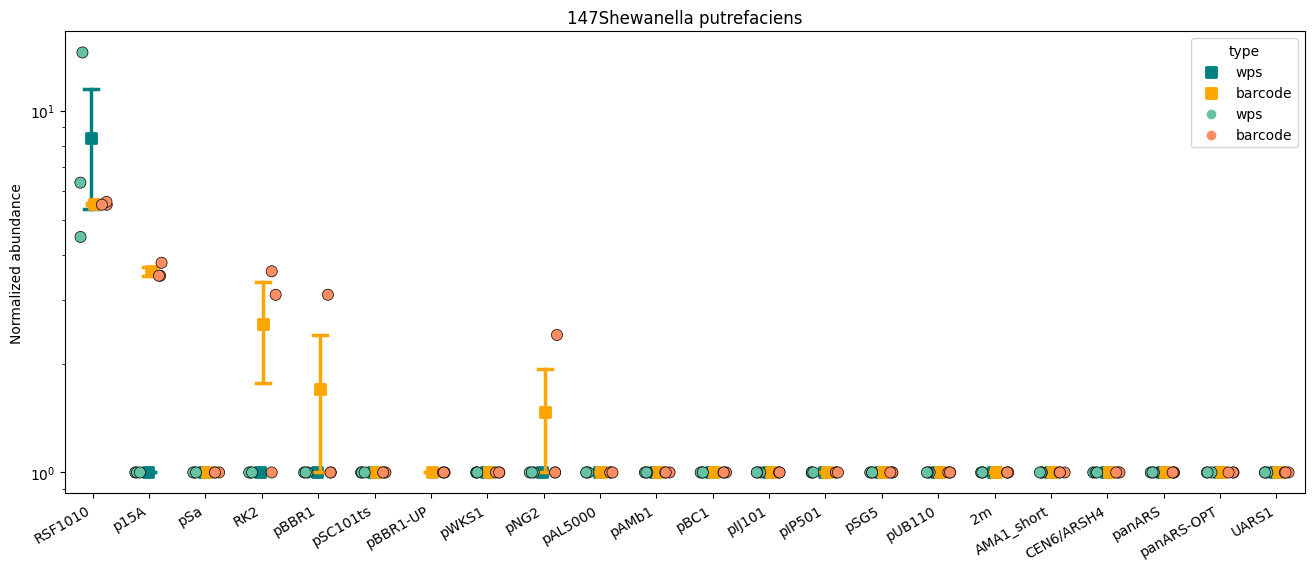

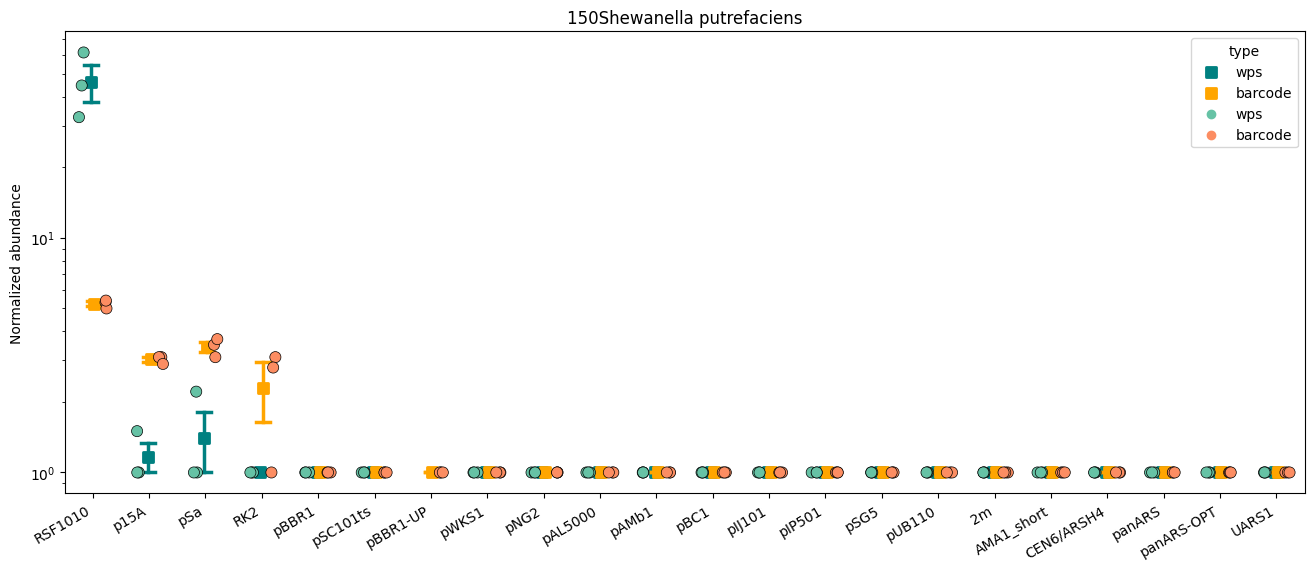

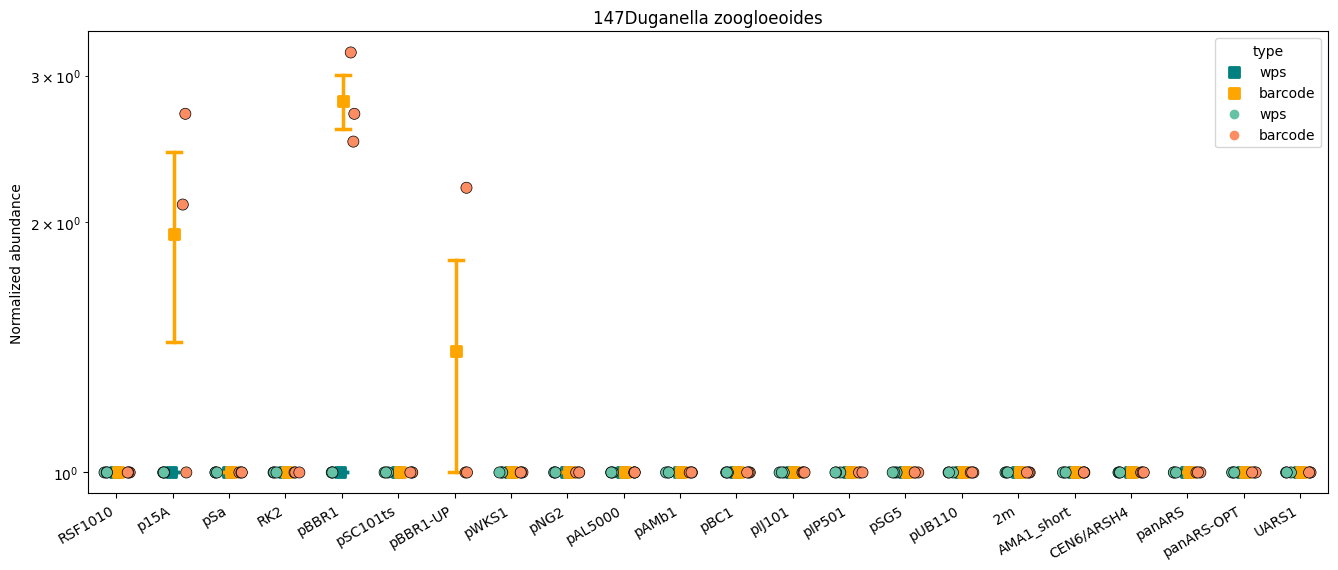

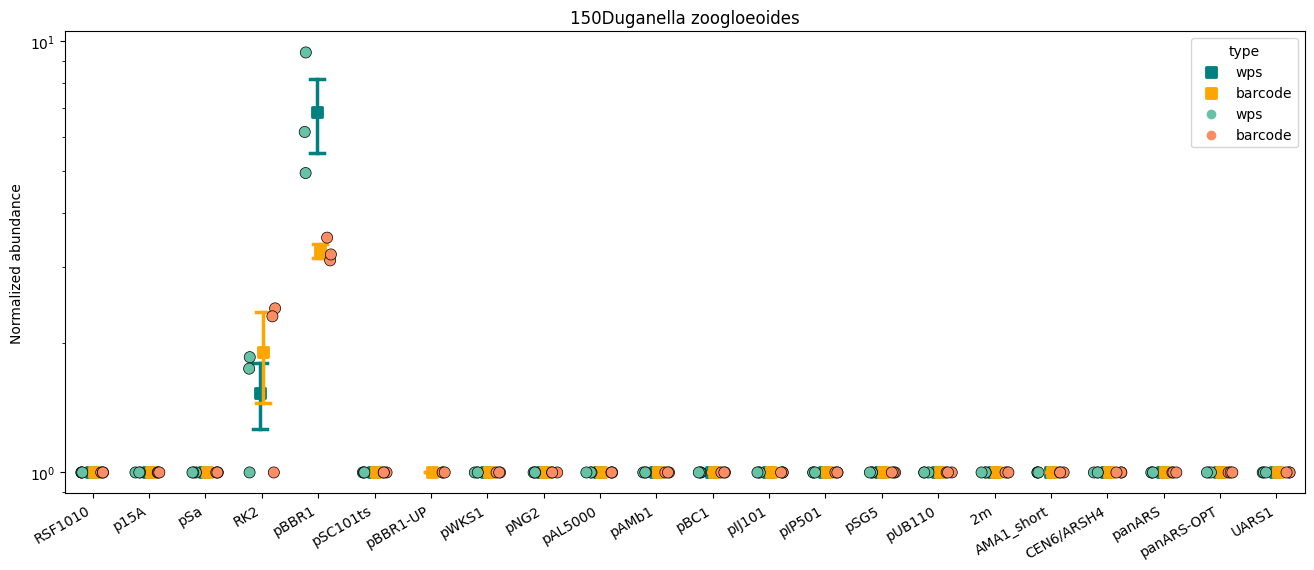

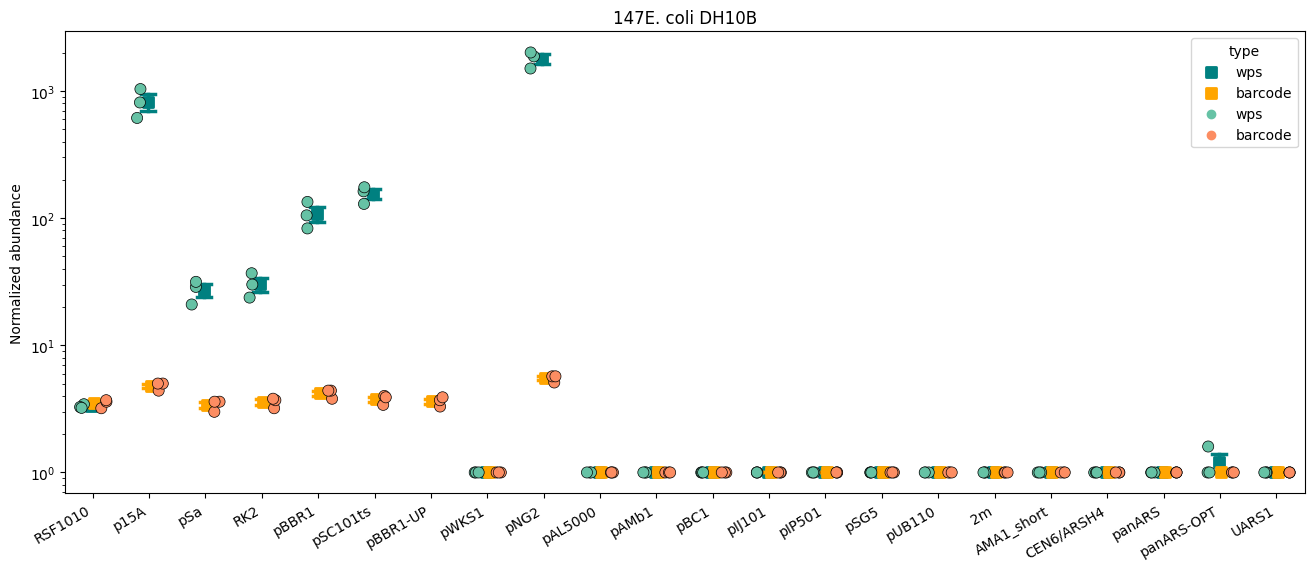

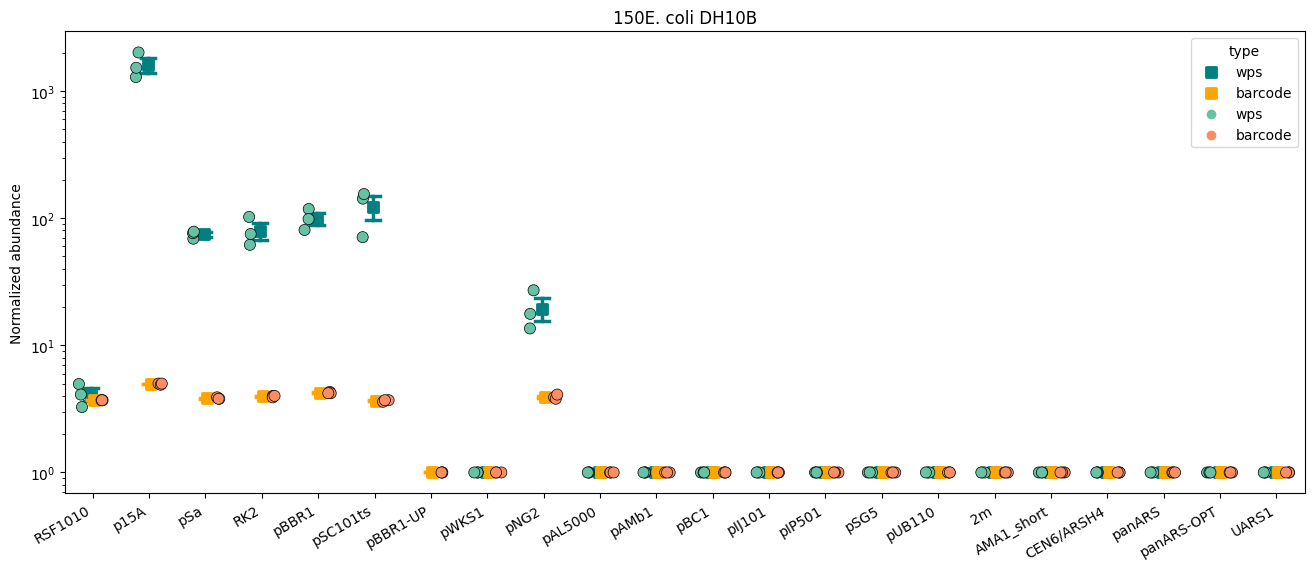

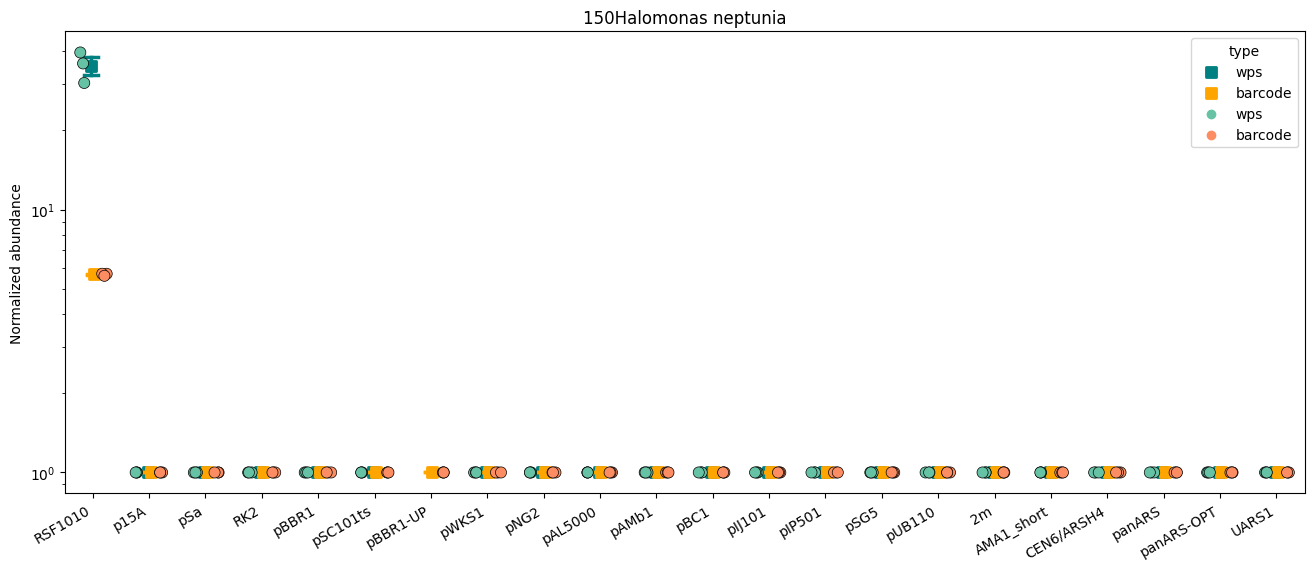

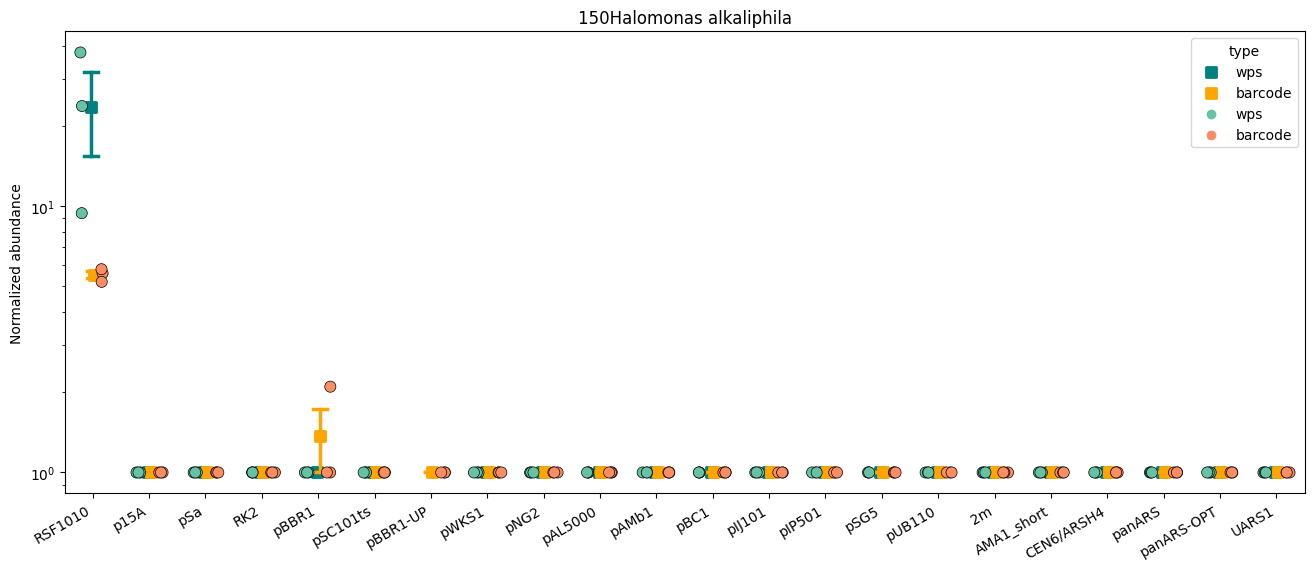

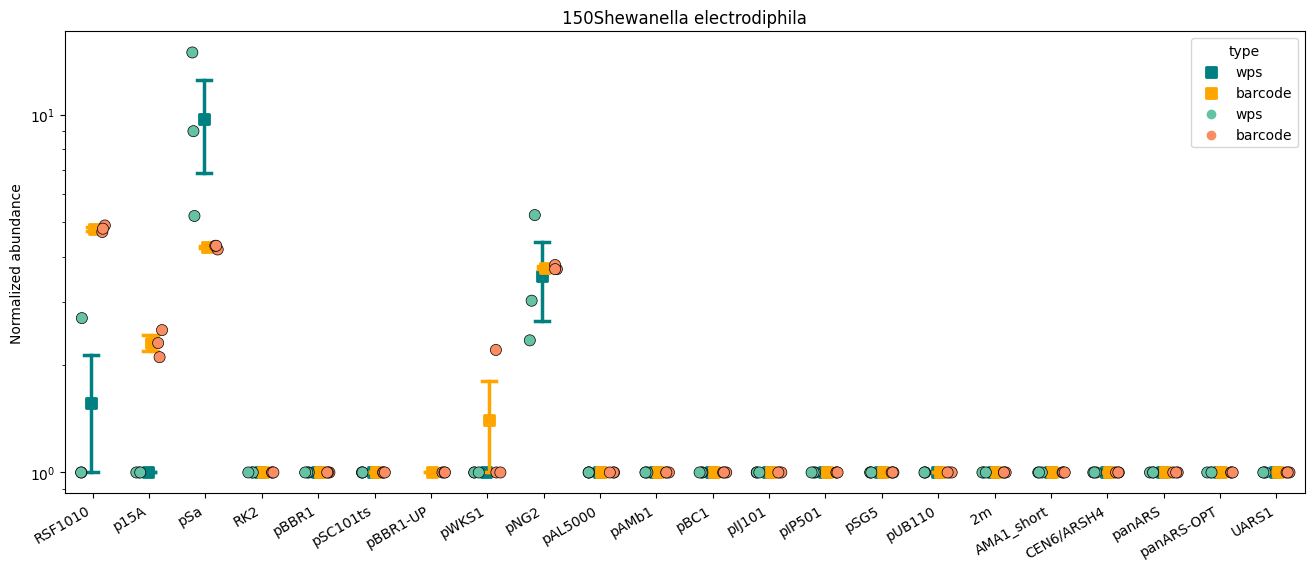

In [119]:
for strain in combined_final.Strain_library.unique():
    merged_strain = combined_final[combined_final.Strain_library == strain].copy()
    plt.figure(figsize=(16,6))
    merged_strain['value'] = merged_strain['value'] + 1
    sns.pointplot(data=merged_strain,x='variable', y='value', errorbar="se", hue='type', dodge=True, join=False, order=barcodes_ordered, markers='s', errwidth=2.5, palette= ['Teal','Orange'], capsize=0.25)
    sns.stripplot(data=merged_strain,x='variable', y='value', hue='type', dodge=True, order=barcodes_ordered, palette='Set2', linewidth=0.5, edgecolor='black', s=8)
    plt.xticks(rotation=30, ha='right')
    plt.title(strain)
    plt.ylabel("Normalized abundance")
    plt.xlabel("")
    plt.yscale("log")
    
    # plt.savefig("plot_" + strain + ".svg")
    plt.show()